# Skript to look at SKS Results and make maps

In [5]:
#import splitwavepy as sw
from obspy import read
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import matplotlib.pyplot as plt
import numpy as np
from obspy.core import UTCDateTime
from itertools import izip_longest as zip_longest

import os 



### Load in the eig matrixes FROM METHODS
### read in and weighted average of directions
### histogram
### implement QC, splitting Intensity, SNR
### Go through Splitting Windows and Classify as SKS or not




Plotting I D E A S
- make Histograms of found directions
- plot mean phi and dt on map (interpolation)
- plot (topographic) map with event and station and ray path
- overview maps of stations and events + histogram of azimuths
- plot waveforms from stations against distance to events
- deviation SKS arrival from tau p on map


In [6]:
## Function to read in  CHEVROT  Files 
path='/media/hein/home2/SplitWave_Results/SKS/Chevrot/'
filename='SKS_Splitting_Chevrot.txt'

def read_SKS_files(path,filename):
    filename = '{0}/{1}'.format(path,filename) #removed first two header lines
    with open(filename) as f:
        content = f.readlines()

    station = ['']*len(content) 
    dt = ['']*len(content) 
    dtlag  = ['']*len(content) 
    fast_dir = ['']*len(content) 
    dfast_dir = ['']*len(content) 

    for i in range(1,len(content)-1):
        data = zip_longest(*(x.split(' ') for x in content[i].splitlines()), fillvalue='\t')

        for row in zip(*data):
            new_data = tuple(np.nan if x == '' else x for x in row)
            line = new_data
            station[i] = line[0][1:-1]            
            dt[i] = float(line[1][1:-2])
            dtlag[i] = float(line[2][1:-2])          
            fast_dir[i] = float(line[3][1:-2])            
            dfast_dir[i] = float(line[4][1:-2])                        

    station = np.asarray(station[1:-1])
    dt = np.asarray(dt[1:-1])
    dtlag = np.asarray(dtlag[1:-1])
    fast_dir = np.asarray(fast_dir[1:-1])
    ## convert from -90-90 to 0-180    
    fast_dir = (fast_dir+180)%180    
    dfast_dir = np.asarray(dfast_dir[1:-1])    
        
    return station,dt,dtlag,fast_dir,dfast_dir

# Function to read in OTHER SKS Files 

def read_SKS_methods(save_loc,method,station):
    
    filename= 'SKS_Splitting_{0}_{1}.txt'.format(station,method)
    filepath = '{0}/../SplitWave_Results/SKS/{1}/{2}'.format(save_loc,method,filename)

    
#    filename = '{0}/{1}'.format(path,filename) #removed first two header lines
    with open(filepath) as f:
        content = f.readlines()

    station = ['']*len(content) 
    st_lat  = ['']*len(content)
    st_lon = ['']*len(content)
    ev_time = ['']*len(content)
    ev_depth = ['']*len(content)
    ev_mag = ['']*len(content)
    ev_lat = ['']*len(content)
    ev_lon = ['']*len(content)
    fast_dir = ['']*len(content)
    dfast_dir = ['']*len(content)
    lag = ['']*len(content)
    dlag = ['']*len(content)
    SNR  = ['']*len(content)
    
    for i in range(1,len(content)-1):
        data = zip_longest(*(x.split(' ') for x in content[i].splitlines()), fillvalue='\t')

        for row in zip(*data):
            new_data = tuple(np.nan if x == '' else x for x in row)
            line = new_data
            station[i] = line[0][1:-1]            
            st_lat[i] = float(line[1][1:-1])
            st_lon[i] = float(line[2][1:-1]) 
            ev_time[i] = UTCDateTime(float(line[3][1:-1]))          
            ev_depth[i] = float(line[4][1:-1])  
            ev_mag[i] = float(line[5][1:-1])  
            ev_lat[i] = float(line[6][1:-1])  
            ev_lon[i] = float(line[7][1:-1])  
            fast_dir[i] = float(line[8][1:-1])  
            dfast_dir[i] = float(line[9][1:-1])  
            lag[i] = float(line[10][1:-1])  
            dlag[i] = float(line[11][1:-1]) 
            
            if line[11][1:-1]=='nan':
                SNR[i] = np.nan
            else:
                SNR[i] = float(line[12][1:-1])
                
    station = np.asarray(station[1:-1])
    st_lat = np.asarray(st_lat[1:-1])
    st_lon = np.asarray(st_lon[1:-1])
    ev_time = np.asarray(ev_time[1:-1])
    ev_depth = np.asarray(ev_depth[1:-1])
    ev_mag = np.asarray(ev_mag[1:-1])
    ev_lat = np.asarray(ev_lat[1:-1])
    ev_lon = np.asarray(ev_lon[1:-1])
    
    fast_dir = np.asarray(fast_dir[1:-1])
    ## convert from -90-90 to 0-180
    fast_dir = (fast_dir+180)%180
    
    dfast_dir = np.asarray(dfast_dir[1:-1])
    lag = np.asarray(lag[1:-1])
    dlag = np.asarray(dlag[1:-1])
    SNR = np.asarray(SNR[1:-1])
    
#     ## sort out values greater 2.6s 
#     thres =  2.5
#     ilag = np.where(lag<2.6)
#     print(len(lag))
#     print(ilag)
#     lag = lag[ilag]
#     print(len(lag))    
#     station = station[ilag]
#     st_lat = st_lat[ilag]
#     st_lon = st_lon[ilag]
#     ev_time = ev_time[ilag]
#     ev_depth = ev_depth[ilag]
#     ev_mag = ev_mag[ilag]
#     ev_lat = ev_lat[ilag]
#     ev_lon = ev_lon[ilag]
#     fast_dir = fast_dir[ilag]
#     dfast_dir = dfast_dir[ilag]
#     dlag = dlag[ilag]
#     SNR = SNR[ilag]

    return station,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir,dfast_dir,lag,dlag,SNR




In [7]:
station='BNALP'
method = ['CrossC','Eig3D','TransM','EigM']
method = method[0]
station_l,st_lat,st_lon,ev_time_1,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_1,dfast_dir_1,lag_1,dlag_1,SNR = read_SKS_methods(save_loc,method,station)


method = ['CrossC','Eig3D','TransM','EigM']
method = method[3]
station_l,st_lat,st_lon,ev_time_2,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_1,dfast_dir_1,lag_1,dlag_1,SNR = read_SKS_methods(save_loc,method,station)



    
### criteria for same event 
#print(ev_time)

NameError: name 'save_loc' is not defined

In [8]:
from tqdm import tqdm
import matplotlib.mlab as mlab
from scipy.stats import norm

save_loc = '/media/hein/home2/SplitWave_Data'
station_list = os.listdir(save_loc)

save_dir = '/media/hein/home2/SplitWave_Results/Comparison/'
#station = station_list[np.random.randint(0,len(station_list))]

#for station in tqdm(station_list[0:1]):
for station in tqdm(station_list[0:1]):    
#    print(station)

    method = ['CrossC','Eig3D','TransM','EigM']
    method = method[0]
    station_l,st_lat,st_lon,ev_time_1,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_1,dfast_dir_1,lag_1,dlag_1,SNR = read_SKS_methods(save_loc,method,station)
    method = ['CrossC','Eig3D','TransM','EigM']
    method = method[1]
    station_l,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_2,dfast_dir_2,lag_2,dlag_2,SNR = read_SKS_methods(save_loc,method,station)
    method = ['CrossC','Eig3D','TransM','EigM']
    method = method[2]
    station_l,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_3,dfast_dir_3,lag_3,dlag_3,SNR = read_SKS_methods(save_loc,method,station)
    method = ['CrossC','Eig3D','TransM','EigM']
    method = method[3]
    station_l,st_lat,st_lon,ev_time_4,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_4,dfast_dir_4,lag_4,dlag_4,SNR = read_SKS_methods(save_loc,method,station)


    station_Chev,dt,dtlag,fast_dir,dfast_dir = read_SKS_files(path,filename)

    plt.figure(figsize=(16,9))

    plt.subplot(2,4,1)
    n,b,p = plt.hist(fast_dir_1,bins=10,color='#0504aa',alpha=0.7, rwidth=0.85,normed=True,weights=SNR,label='CrossC')
    plt.vlines(x=fast_dir[np.where(station_Chev==station)][0],ymin=0,ymax=np.max(n),color='#DC143C',alpha=0.5,label='Chevrot: $\phi$='+'{0}'.format(round(fast_dir[np.where(station_Chev==station)][0],2))+'$^\circ \pm$'+str(round(dfast_dir[np.where(station_Chev==station)][0],3)))
    plt.vlines(x=fast_dir[np.where(station_Chev==station)][0]+dfast_dir[np.where(station_Chev==station)][0],ymin=0,ymax=np.max(n),color='#DC143C',alpha=0.5,linestyle='dashed') 
    plt.vlines(x=fast_dir[np.where(station_Chev==station)][0]-dfast_dir[np.where(station_Chev==station)][0],ymin=0,ymax=np.max(n),color='#DC143C',alpha=0.5,linestyle='dashed')    

   
    plt.xlabel('$\phi$')
    plt.ylabel('Probability')
    plt.title('Fast direction')    
    plt.xlim(0,180)     
    plt.legend()

    plt.subplot(2,4,2)
    n,b,p = plt.hist(fast_dir_2,bins=10,color='#A2CD5A',alpha=0.7, rwidth=0.85,normed=True,weights=SNR,label='Eig3D')
    plt.vlines(x=fast_dir[np.where(station_Chev==station)][0],ymin=0,ymax=np.max(n),color='#DC143C',alpha=0.5,label='Chevrot: $\phi$='+'{0}'.format(round(fast_dir[np.where(station_Chev==station)][0],2))+'$^\circ \pm$'+str(round(dfast_dir[np.where(station_Chev==station)][0],3)))

    plt.xlabel('$\phi$')
    plt.xlim(0,180)     

    plt.legend()

    plt.subplot(2,4,3)
    n,b,p = plt.hist(fast_dir_3,bins=10,color='#D2691E',alpha=0.7, rwidth=0.85,normed=True,weights=SNR,label='TransM')
    plt.vlines(x=fast_dir[np.where(station_Chev==station)][0],ymin=0,ymax=np.max(n),color='#DC143C',alpha=0.5,label='Chevrot: $\phi$='+'{0}'.format(round(fast_dir[np.where(station_Chev==station)][0],2))+'$^\circ \pm$'+str(round(dfast_dir[np.where(station_Chev==station)][0],3)))
    plt.xlabel('$\phi$')
    plt.xlim(0,180)     
    plt.legend()
    
    plt.subplot(2,4,4)
    n,b,p = plt.hist(fast_dir_4,bins=10,color='palevioletred',alpha=0.7, rwidth=0.85,normed=True,weights=SNR,label='EigM')
    plt.vlines(x=fast_dir[np.where(station_Chev==station)][0],ymin=0,ymax=np.max(n),color='#DC143C',alpha=0.5,label='Chevrot: $\phi$='+'{0}'.format(round(fast_dir[np.where(station_Chev==station)][0],2))+'$^\circ \pm$'+str(round(dfast_dir[np.where(station_Chev==station)][0],3)))
    plt.xlabel('$\phi$')
    plt.xlim(0,180)    
    plt.legend()    
    
    plt.subplot(2,4,5)
    n,b,p = plt.hist(lag_1,bins=10,color='#0504aa',alpha=0.7, rwidth=0.85,normed=1,weights=SNR,label='CrossC')
    plt.vlines(x=dt[np.where(station_Chev==station)][0],ymin=0,ymax=np.max(n),color='#DC143C',alpha=0.5,label='Chevrot: $\Delta$ t='+'{0} s'.format(round(dt[np.where(station_Chev==station)][0],2))+'$\pm$'+str(round(dtlag[np.where(station_Chev==station)][0],3)))

    plt.xlabel('$\Delta$ t')
    plt.ylabel('Occurence')
    plt.title('Time lag')    
    plt.xlim(0,3)    
    plt.legend()

    plt.subplot(2,4,6)
    n,b,p = plt.hist(lag_2,bins=10,color='#A2CD5A',alpha=0.7, rwidth=0.85,normed=1,weights=SNR,label='Eig3D')
    plt.vlines(x=dt[np.where(station_Chev==station)][0],ymin=0,ymax=np.max(n),color='#DC143C',alpha=0.5,label='Chevrot: $\Delta$ t='+'{0} s'.format(round(dt[np.where(station_Chev==station)][0],2))+'$\pm$'+str(round(dtlag[np.where(station_Chev==station)][0],3)))

    plt.xlabel('$\Delta$ t')
    plt.legend()

    plt.subplot(2,4,7)
    n,b,p = plt.hist(lag_3,bins=10,color='#D2691E',alpha=0.7, rwidth=0.85,normed=1,weights=SNR,label='TransM')
    plt.vlines(x=dt[np.where(station_Chev==station)][0],ymin=0,ymax=np.max(n),color='#DC143C',alpha=0.5,label='Chevrot: $\Delta$ t='+'{0} s'.format(round(dt[np.where(station_Chev==station)][0],2))+'$\pm$'+str(round(dtlag[np.where(station_Chev==station)][0],3)))
    plt.xlabel('$\Delta$ t')
    plt.xlim(0,3)    
    plt.legend()

    plt.subplot(2,4,8)
    n,b,p = plt.hist(lag_4,bins=10,color='palevioletred',alpha=0.7, rwidth=0.85,normed=1,weights=SNR,label='EigM')
    plt.vlines(x=dt[np.where(station_Chev==station)][0],ymin=0,ymax=np.max(n),color='#DC143C',alpha=0.5,label='Chevrot: $\Delta$ t='+'{0} s'.format(round(dt[np.where(station_Chev==station)][0],2))+'$\pm$'+str(round(dtlag[np.where(station_Chev==station)][0],3)))
    plt.xlabel('$\Delta$ t')
    plt.xlim(0,3)
    
    plt.legend()    
    
    plt.suptitle('station: {0}, SNR weighted Histograms of fast direction and time lag for all methods'.format(station))
    plt.savefig('{0}/{1}_method_comparison.png'.format(save_dir,station))
    plt.close()
    
## go through measurements and 
## check agreement among stations and 

## and look for SNR threshold
## --> then accept and plot final





  0%|          | 0/1 [00:00<?, ?it/s]/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


In [9]:
## CLEAN UP A BIT AND ORDER IT 

## implement the two other methods

#0504aa
#palevioletred

## Aus Baruols
val_B = [43.95,4.11,1.34, 0.13, 15]

station='LLS'

method = ['CrossC','Eig3D','TransM','EigM']
method = method[0]
station_l,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_1,dfast_dir_1,lag_1,dlag_1,SNR = read_SKS_methods(save_loc,method,station)

method = ['CrossC','Eig3D','TransM','EigM']
method = method[2]
station_l,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_4,dfast_dir_4,lag_4,dlag_4,SNR = read_SKS_methods(save_loc,method,station)

method = ['CrossC','Eig3D','TransM','EigM']
method = method[3]
station_l,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_4,dfast_dir_4,lag_4,dlag_4,SNR = read_SKS_methods(save_loc,method,station)

idx = np.where(station_Chev==station)

omega,delta,igood_nonnull =get_Q(fast_dir_1,fast_dir_4,lag_1,lag_4)

fig, ax = plt.subplots(figsize=(16, 9))
plt.subplot(121)
bins = 25
#ax = sns.distplot(fast_dir_1,bins=bins, hist=False, kde=True, color='#A2CD5A', vertical=False, norm_hist=True, axlabel='$\phi$', label='EV', ax=None)

p=sns.kdeplot(fast_dir_4, shade=False, color='#D2691E', label='SC')
x,y = p.get_lines()[0].get_data()
#plt.plot(x1[np.argmax(y1)],np.max(y1),marker='x',color='#D2691E',label='$\phi_{max}=$'+'{0}$^\circ$'.format(round(x1[np.argmax(y1)],2)))

p=sns.kdeplot(fast_dir_1, shade=False, color='#A2CD5A', label='RC')


plt.vlines(fast_dir[idx],0,np.max(y)*1.2,color='green',linewidth=2,label='Chevrot')
plt.vlines(fast_dir[idx]+dfast_dir[idx],0,np.max(y)*1.2,color='green',linestyle='dashed',linewidth=2)
plt.vlines(fast_dir[idx]-dfast_dir[idx],0,np.max(y)*1.2,color='green',linestyle='dashed',linewidth=2)

plt.vlines(43.95,0,np.max(y)*1.2,color='yellow',linewidth=2,label='Barruol')
plt.vlines(43.95+4.11,0,np.max(y)*1.2,color='yellow',linewidth=2,linestyle='dashed')
plt.vlines(43.95-4.11,0,np.max(y)*1.2,color='yellow',linewidth=2,linestyle='dashed')

#ax.set_ylim(0,0.02)
plt.xlabel('$\phi$')
plt.title('Fast axis')
plt.xticks(np.arange(0,210,30))
plt.xlim(0,180)
#plt.ylim(0,np.max(y)*1.5)

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 1.0), shadow=True)

plt.subplot(321)
# ax2 = sns.distplot(lag_4,bins=bins, hist=False, kde=True, color='#D2691E', vertical=False, norm_hist=True, axlabel='dt', label='RC', ax=None)
# ax2 = sns.distplot(lag_4[igood_nonnull],bins=None, hist=True, kde=False, color='#D2691E', vertical=False, norm_hist=True, axlabel='dt', label='RC-good SKS', ax=None)
p = sns.kdeplot(lag_4, shade=False, color='#D2691E', label='SC')
#ax2.plot(x1[np.argmax(y1)],np.max(y1),marker='x',color='#D2691E',label='dt')
x,y = p.get_lines()[0].get_data()
p = sns.kdeplot(lag_1, shade=False, color='#A2CD5A', label='RC')


plt.vlines(dt[idx],0,np.max(y)*1.2,color='green',linewidth=3,label='Chevrot')
plt.vlines(dt[idx]+dtlag[idx],0,np.max(y)*1.2,color='green',linestyle='dashed',linewidth=3)
plt.vlines(dt[idx]-dtlag[idx],0,np.max(y)*1.2,color='green',linestyle='dashed',linewidth=3)

plt.vlines(1.3,0,np.max(y)*1.2,color='yellow',linewidth=3,label='Barruol')
plt.vlines(1.3+0.13,0,np.max(y)*1.2,color='yellow',linewidth=3,linestyle='dashed')
plt.vlines(1.3-0.13,0,np.max(y)*1.2,color='yellow',linewidth=3,linestyle='dashed')

plt.grid()
plt.ylim(0,np.max(y)*1.5)
plt.xlim(0,3.5)
plt.xticks(np.arange(0,4,0.5))
plt.title('Time lag')
plt.legend(loc='upper center', bbox_to_anchor=(0.8, 0.9), shadow=True)
plt.subplot(123)


fig.suptitle('station: {0}'.format(station))

#ax3 = plt.subplot(123)


NameError: name 'get_Q' is not defined

In [14]:


import math
## define quality criteria
def Q(fastev,lagev,fastrc,lagrc):
    """Following Wuestefeld et al. 2010"""
#    omega = math.fabs((fastev - fastrc + 3645)%90 - 45) / 45
    omega = math.fabs((fastev - fastrc + 360)%90) / 45
#    omega = math.fabs((fastev - fastrc))/45
    delta = lagrc / lagev
    dnull = math.sqrt(delta**2 + (omega-1)**2) * math.sqrt(2)
    dgood = math.sqrt((delta-1)**2 + omega**2) * math.sqrt(2)
    if dnull < dgood:
        return -(1 - dnull)
    else:
        return (1 - dgood)
    
    
def get_Q(fast_dir_1,fast_dir_4,lag_1,lag_4):
    
    rho_l = 0.2
    rho_u = 0.1
    delta_y = 8

    omega = []
    delta = []
    for i in range(0,len(fast_dir_4)):
        tmp = math.fabs((fast_dir_4[i]-fast_dir_1[i]+ 360)%90)
        tmp2 = lag_1[i]/lag_4[i]    ## SC/RC
        omega.append(tmp)    
        delta.append(tmp2)
                
    omega = np.asarray(omega)    
    delta = np.asarray(delta)
        

    igood_nonnull = np.where((delta<=1+rho_u) & (delta>=1-rho_l) & (omega<=delta_y))
    
    return omega,delta,igood_nonnull






### Automatic QUALITY DETERMINATION CRITERIA
('Quality: Fast XC', array([  94.,   54.,  112.,   96.,   96.,   92.,    8.,   90.]))
('error XC', array([ 12.5,  28.5,  35. ,  17.5,  45. ,  36.5,  45. ,  32. ]))
('Quality: Fast EV', array([  96.,   56.,  108.,   96.,   96.,   92.,    6.,   90.]))
('error XC', array([ 11. ,   2.5,  45. ,  16. ,  30. ,  23.5,  45. ,  13. ]))
TIME LAGS
('Quality: dt XC', array([ 1.4,  2. ,  0.4,  1. ,  1.4,  0.8,  2.2,  1. ]))
('Quality: dt EV', array([ 1.4,  2. ,  0.4,  1. ,  1.4,  0.8,  2.2,  1. ]))
('SNR ', array([  51.5029,  118.495 ,   22.354 ,   57.7859,    0.    ,   16.8065,
         12.9087,   22.7779]))
AVERAGES
CROSS CORRLEATION
('mean XC', 12.75)
('SNR weighted mean XC', 25.047434349896196)
('inverse error weighted mean XC', 11.688530994398368)
EIGENVECTOR METHOD
('mean EV', 12.5)
('SNR weighted mean EV', 25.790129163941952)
('inverse Error weighted mean EV', 32.1567598950489)
###############
('mean XC', 1.2749999999999999)
('mean EV', 1.274999999

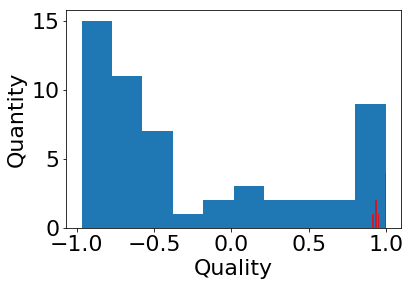

In [15]:
Quality = []
omega =[]
delta = []

for i in range(0,len(fast_dir_4)):
    tmp = Q(fast_dir_4[i],lag_4[i],fast_dir_1[i],lag_1[i]) 
    Quality.append(tmp)

Quality = np.asarray(Quality)
iQ = np.where(Quality>0.9)

plt.hist(Quality)
plt.hist(Quality[iQ],alpha=0.8,color='red',zorder=2)
plt.xlabel('Quality')
plt.ylabel('Quantity')


print('### Automatic QUALITY DETERMINATION CRITERIA')
print('Quality: Fast XC',fast_dir_1[iQ])
print('error XC', dfast_dir_1[iQ])
print('Quality: Fast EV',fast_dir_4[iQ])
print('error XC', dfast_dir_4[iQ])
print('TIME LAGS')
print('Quality: dt XC',lag_1[iQ])
print('Quality: dt EV',lag_4[iQ])
print('SNR ',SNR[iQ])
print('AVERAGES')
print('CROSS CORRLEATION')
print('mean XC', np.mean((fast_dir_1[iQ]+360)%90))
print('SNR weighted mean XC', np.average((fast_dir_1[iQ]+360)%90,weights=SNR[iQ]))
print('inverse error weighted mean XC', np.average((fast_dir_1[iQ]+360)%90,weights=1/dfast_dir_1[iQ]))
      
print('EIGENVECTOR METHOD')
print('mean EV', np.mean((fast_dir_4[iQ]+360)%90))
#print('error EV', np.mean((dfast_dir_4[iQ])))
print('SNR weighted mean EV', np.average((fast_dir_4[iQ]+360)%90,weights=SNR[iQ]))
print('inverse Error weighted mean EV', np.average((fast_dir_4[iQ]+360)%90,weights=1/dfast_dir_4[iQ]))
print('###############')
print('mean XC', np.mean(lag_1[iQ]))
print('mean EV', np.mean(lag_4[iQ]))
#print(ev_time[iQ])
print('Found indices ',iQ)
print('### Compare with CHEVROT')
idx = np.where(station_Chev==station)
print('Chevrot fast direction',fast_dir[idx])
print('Chevrot time lag',dt[idx])

100%|██████████| 1/1 [00:00<00:00, 26.46it/s]

['LLS']


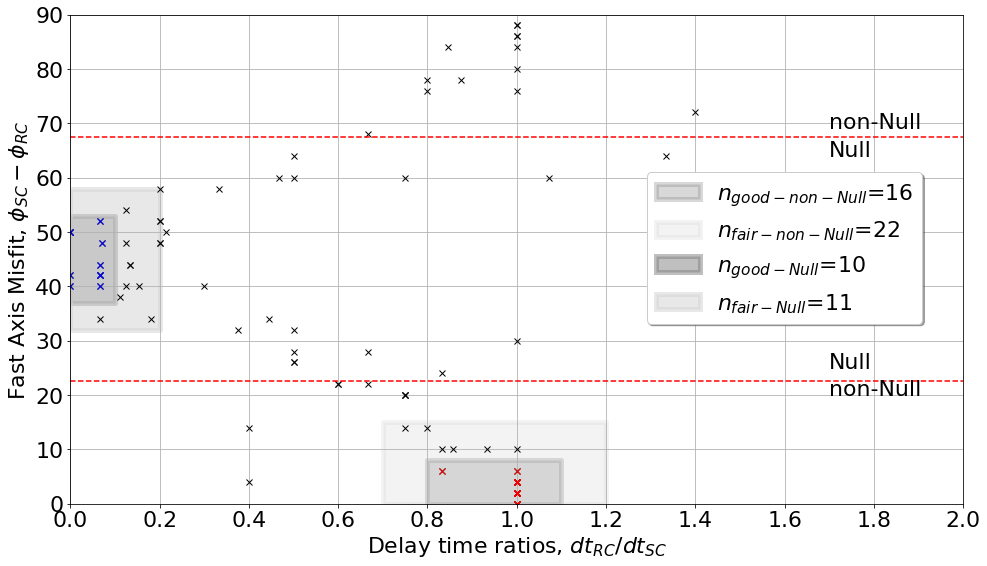

('Total SKS ', 85)
('N: good SKS ', 16)
('N: fair SKS ', 22)
('N: good Null ', 10)
('N: fair Null ', 11)


In [28]:

rho_l = 0.2
rho_u = 0.1
delta_y = 8

rho_l_2 = 0.3
rho_u_2 = 0.2
delta_y_2 = 15

save_img = '/media/hein/home2/SplitWave_Results/Project_images/'


plt.rcParams.update({'font.size': 22})
#plt.rc('text', usetex=True)
plt.figure(figsize=(16,9))


print(station_list)

n_total =0

n_good_nonnull = 0
n_fair_nonnull = 0

n_good_null = 0
n_fair_null = 0

#station_list = ['LLS']

for station in tqdm(station_list):    
#    print(station)

    method = ['CrossC','Eig3D','TransM','EigM']
    method = method[0]
    station_l,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_1,dfast_dir_1,lag_1,dlag_1,SNR = read_SKS_methods(save_loc,method,station)
    
    method = ['CrossC','Eig3D','TransM','EigM']
    method = method[2]
    station_l,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_4,dfast_dir_4,lag_4,dlag_4,SNR = read_SKS_methods(save_loc,method,station)

    
    method = ['CrossC','Eig3D','TransM','EigM']
    method = method[3]
    station_l,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_3,dfast_dir_3,lag_3,dlag_3,SNR = read_SKS_methods(save_loc,method,station)    

    omega = []
    delta = []
    for i in range(0,len(fast_dir_4)):
        tmp = math.fabs((fast_dir_4[i]-fast_dir_1[i]+ 360)%90)
        tmp2 = lag_1[i]/lag_4[i]    ## SC/RC
        omega.append(tmp)    
        delta.append(tmp2)

        
    omega = np.asarray(omega)    
    delta = np.asarray(delta)
    
#     print(lag_1[np.where(delta==1)])
#     print(lag_4[np.where(delta==1)])    
    
#     thresh = 0.2
#     iSort_t = np.where()
    
#     omega = omega[iSort_t]
#     delta = delta[iSort_t]    
    
    

    igood_nonnull = np.where((delta<=1+rho_u) & (delta>=1-rho_l) & (omega<=delta_y) )
    ifair_nonnull = np.where((delta<=1+rho_u_2) & (delta>=1-rho_l_2)  & (omega<=delta_y_2))    

    igood_null = np.where((delta<=rho_u) & (omega>=37) & (omega<=53))
    ifair_null = np.where((delta<=rho_u) & (omega>=32) & (omega<=58))
    
    n_total = n_total + len(omega)
    n_good_nonnull = n_good_nonnull + len(igood_nonnull[0])
    n_fair_nonnull = n_fair_nonnull+ len(ifair_nonnull[0])    
    n_good_null = n_good_null + len(igood_null[0])
    n_fair_null = n_fair_null + len(ifair_null[0])        
    
   
    plt.plot(delta,omega,'x', color='black')
    plt.plot(delta[igood_nonnull],omega[igood_nonnull],'rx')
    plt.plot(delta[igood_null],omega[igood_null],'bx')    
    



n_total = np.sum(n_total)
n_good_nonnull = np.sum(n_good_nonnull)
n_fair_nonnull = np.sum(n_fair_nonnull)
n_good_null = np.sum(n_good_null)
n_fair_null = np.sum(n_fair_null)


plt.plot([0,2],[22.5,22.5],color='red',linestyle='dashed')
plt.text(1.7, 25, 'Null')
plt.text(1.7, 20, 'non-Null')
plt.plot([0,2],[67.5,67.5],color='red',linestyle='dashed')
plt.text(1.7, 64, 'Null')
plt.text(1.7, 69, 'non-Null')
plt.fill_between([1-rho_l, 1+rho_u], [0, 0],[delta_y,delta_y],color='gray', alpha=0.3,lw=5, edgecolor='black',label='$n_{good-non-Null}}$'+'={0}'.format(n_good_nonnull))
plt.fill_between([1-rho_l_2, 1+rho_u_2], [0, 0],[delta_y_2,delta_y_2],color='lightgray', facecolor='black',lw=5, alpha=0.25, label='$n_{fair-non-Null}}$'+'={0}'.format(n_fair_nonnull))
plt.fill_between([0, rho_u], [37, 37],[53,53], color='gray', facecolor='black',lw=5, alpha=0.5, label='$n_{good-Null}}$'+'={0}'.format(n_good_null))
plt.fill_between([0, rho_u_2], [32, 32], [58,58], color='lightgray', facecolor='black',lw=5, alpha=0.5, label='$n_{fair-Null}}$'+'={0}'.format(n_fair_null))

plt.xlim(0,2)
plt.ylim(0,90)
plt.xticks(np.arange(0,2.2,0.2))
plt.yticks(np.arange(0,100,10))

plt.xlabel('Delay time ratios, $dt_{RC}$/$dt_{SC}$')
plt.ylabel('Fast Axis Misfit, $\phi_{SC}-\phi_{RC}$')
plt.grid(linestyle='-')
plt.legend(loc='upper center', bbox_to_anchor=(0.8, 0.7), shadow=True)
plt.savefig('{0}/Quality_criteria.png'.format(save_img),dpi=150)
plt.show()

print('Total SKS ',n_total)
print('N: good SKS ',n_good_nonnull)
print('N: fair SKS ',n_fair_nonnull)
print('N: good Null ',n_good_null)
print('N: fair Null ',n_fair_null)


In [47]:
print('Quality: Fast XC',(fast_dir_1[igood_nonnull]+360)%90)
print('error XC', (dfast_dir_1[igood_nonnull]))
print('Quality: Fast EV',(fast_dir_4[igood_nonnull]+360)%90)
print('error EV', (dfast_dir_4[igood_nonnull]))
print('TIME LAGS')
print('Quality: dt XC',dlag_1[igood_nonnull])
print('Quality: dt EV',dlag_4[igood_nonnull])
print('SNR ',SNR[igood_nonnull])

print('#### AVERAGES')
print('CROSS CORRLEATION')
print('mean XC', np.mean((fast_dir_1[igood_nonnull]+360)%90))
print('error XC', np.mean((dfast_dir_1[igood_nonnull])))
print('SNR weighted mean XC', np.average((fast_dir_1[igood_nonnull]+360)%90, weights=SNR[igood_nonnull]))

print('TransM')
print('mean EV', np.mean((fast_dir_4[igood_nonnull]+360)%90))
print('error EV', np.mean((dfast_dir_4[igood_nonnull])))
print('SNR weighted mean EV', np.average((fast_dir_4[igood_nonnull]+360)%90, weights=SNR[igood_nonnull]))

print('EIGENVECTOR METHOD')
print('mean EV', np.mean((fast_dir_3[igood_nonnull]+360)%90))
print('error EV', np.mean((dfast_dir_3[igood_nonnull])))
print('SNR weighted mean EV', np.average((fast_dir_4[igood_nonnull]+360)%90, weights=SNR[igood_nonnull]))
print('###############')
print('mean XC', np.mean(dlag_1[igood_nonnull]))
print('mean TM', np.mean(dlag_4[igood_nonnull]))
print('mean EV', np.mean(dlag_3[igood_nonnull]))


print(station)
idx = np.where(station_Chev==station)
print('WüsteFeld Quality determination Technique')
print('Chevrot fast direction',fast_dir[idx])
print('Chevrot time lag',dt[idx])

('Quality: Fast XC', array([ 48.,  50.,  78.,  74.,  44.,  50.,  30.,  52.,  46.,  42.,  74.,
        52.,  56.,  52.,  86.,  70.]))
('error XC', array([  4.5,  26. ,   6. ,  21. ,   4. ,   5. ,  25.5,   8.5,   8.5,
         3. ,  45. ,   2. ,   2. ,   5.5,  23. ,  19.5]))
('Quality: Fast EV', array([ 44.,  30.,  14.,  82.,  24.,  18.,  54.,  26.,  36.,  42.,  42.,
        22.,  24.,  74.,  84.,  68.]))
('error EV', array([  3. ,   5.5,  18. ,  22.5,   5.5,   8. ,  18. ,  10.5,   5. ,
         3.5,   4. ,   8. ,   8. ,  45. ,  28.5,  19.5]))
TIME LAGS
('Quality: dt XC', array([ 0.15,  0.75,  0.35,  0.5 ,  0.2 ,  0.2 ,  0.65,  0.3 ,  0.55,
        0.1 ,  0.8 ,  0.05,  0.25,  0.35,  0.75,  0.3 ]))
('Quality: dt EV', array([ 0.05,  0.15,  0.35,  0.75,  0.2 ,  0.15,  0.55,  0.25,  0.15,
        0.1 ,  0.15,  0.2 ,  0.2 ,  0.8 ,  0.7 ,  0.5 ]))
('SNR ', array([ 1122.61   ,    15.4559 ,     8.56707,   172.299  ,    68.5347 ,
          65.3167 ,    13.4453 ,    45.2635 ,    54.3081 ,   336.41

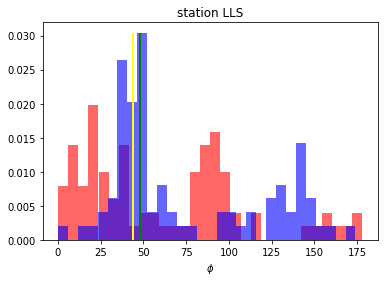

In [604]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

val_B = [43.95,4.11,1.34, 0.13, 15]

#plt.hist((fast_dir_1+180)%180)
bins=30
plt.hist(fast_dir_1,color='red',bins=bins,alpha=0.6,normed=True,label='CrossC')
n,b,p = plt.hist(fast_dir_4,color='blue',bins=bins,alpha=0.6,normed=True,label='EigM')
val_B = [43.95,4.11,1.34, 0.13, 15]
plt.vlines(fast_dir[idx],0,np.max(n),color='green',linewidth=2,label='Chevrot')
plt.vlines(43.95,0,np.max(n),color='yellow',linewidth=2,label='Barruol')
plt.xlabel('$\phi$')
plt.title('station {0}'.format(station))
plt.show()


# quality_dirs_1 = (fast_dir_4[ix]+180)%180
# quality_ts_1 = lag_4[ix]

# for i in range(0,len(quality_dirs)):
#     u,v = calc_u_v(quality_ts_1[i],quality_dirs_1[i])
#     a = plt.quiver(0, 0, u, v,pivot='mid',color='red', alpha=0.1, headlength=0, headwidth = 1, label='Quality EV',scale=scale)

#fast_dir_1 =fast_dir_1
# ws = lag_1
# wd = fast_dir_1-180
# ax = WindroseAxes.from_ax()
# ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
# ax.set_legend()
          
          
## to Do

## Plot upper figure better

          
## plot histogram and arrows next to it
## Use automatic Criteria Q 
## or Data-based!!
## use weighted average ? 
## fully automatize and use seaborn distribution
## get Barruol           

(array([ 1,  3, 10, 14, 31, 35, 46, 68, 75]),)
(array([ 1,  3, 35, 40, 45, 46]),)
8
[ 47.79369193]


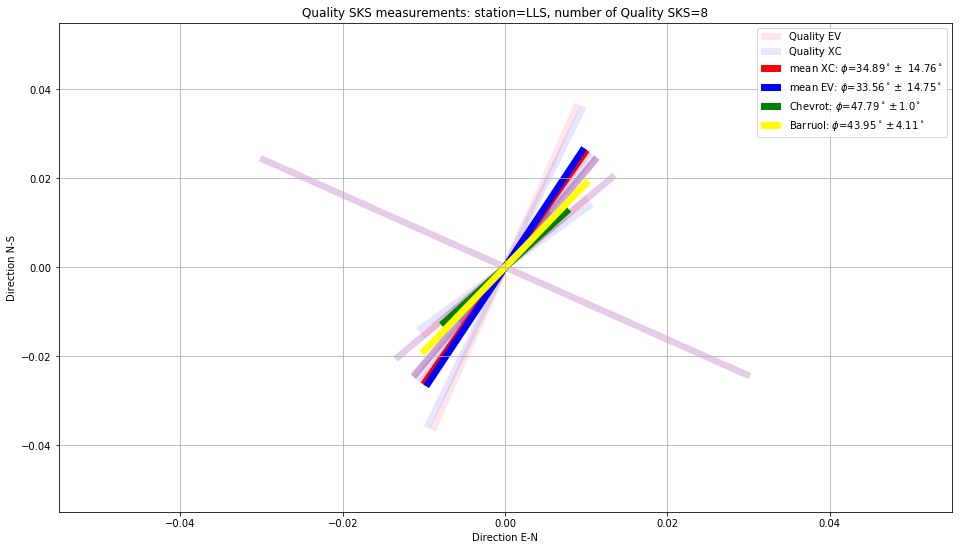

In [605]:
print(iQ)
print(ix)
#iQ  =np.where(Quality>0.9)
#print(fast_dir_1[iQ])

#plt.hist(Quality[iQ],alpha=0.5,color='red')
#plt.hist(fast_dir_1,color='blue')
#plt.hist((fast_dir_1[iQ]+360)%360,alpha=0.5,color='red')

#plt.hist(Quality)

quality_dirs_1 = fast_dir_4[iQ]
quality_ts_1 = lag_4[iQ]

quality_dirs_2 = fast_dir_1[iQ]
quality_ts_2 = lag_1[iQ]

print(len(quality_dirs))
scale=5

plt.figure(figsize=(16,9))
for i in range(0,len(quality_dirs)):
    u,v = calc_u_v(quality_ts_1[i],quality_dirs_1[i])
    a = plt.quiver(0, 0, u, v,pivot='mid',color='red', alpha=0.1, headlength=0, headwidth = 1, label='Quality EV',scale=scale)
    u,v = calc_u_v(quality_ts_2[i],quality_dirs_2[i])    
    b = plt.quiver(0, 0, u, v,pivot='mid',color='blue', alpha=0.1, headlength=0, headwidth = 1, label='Quality XC',scale=scale)    


    
u,v = calc_u_v(np.mean(lag_1[iQ]),np.mean((fast_dir_1[iQ]+360)%90))
c = plt.quiver(0, 0, u, v,pivot='mid',color='red', alpha=1, headlength=0, headwidth = 1, linewidth=1,label='mean XC: $\phi$={0}$^\circ \pm$ {1}$^\circ$'.format(round(np.mean((fast_dir_1[iQ]+360)%90),2),round(np.std((fast_dir_1[iQ]+360)%90),2)),scale=scale)    
u,v = calc_u_v(np.mean(lag_4[iQ]),np.mean((fast_dir_4[iQ]+360)%90))
d = plt.quiver(0, 0, u, v,pivot='mid',color='blue', alpha=1, headlength=0, headwidth = 1, linewidth=1,label='mean EV: $\phi$={0}$^\circ \pm$ {1}$^\circ$'.format(round(np.mean((fast_dir_4[iQ]+360)%90),2),round(np.std((fast_dir_4[iQ]+360)%90),2)),scale=scale)    

u,v = calc_u_v(dt[idx],fast_dir[idx]) 
e = plt.quiver(0, 0, u, v,pivot='mid',color='green', alpha=1, headlength=0, headwidth = 1, linewidth=3,label='Chevrot: $\phi$={0}$^\circ \pm {1}^\circ$'.format(round(fast_dir[idx],2),round(dfast_dir[idx])),scale=scale)


## plot Barroul
#Station	Lat. (°N)	Lon. (°E)	ϕ (°)	Error_ϕ (°)	δt (s)	Error_δt (s)	Number of measurements

val_B = [43.95,4.11,1.34, 0.13, 15]

u,v = calc_u_v(val_B[2],val_B[0]) 
f = plt.quiver(0, 0, u, v,pivot='mid',color='yellow', alpha=1, headlength=0, headwidth = 1, linewidth=3,label='Barruol: $\phi$={0}$^\circ \pm {1}^\circ$'.format(val_B[0],val_B[1]),scale=scale)

print(fast_dir[idx])


## plot Mean 

## plot times together 

plt.legend(handles = [a,b,c,d,e,f])
plt.xlabel('Direction E-N')
plt.ylabel('Direction N-S')
plt.title('Quality SKS measurements: station={0}, number of Quality SKS={1}'.format(station,len(quality_dirs)))
plt.grid()
plt.show()    

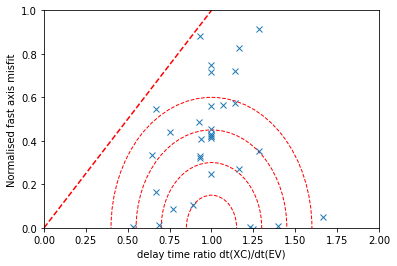

In [524]:

Quality = []
for i in range(0,len(fast_dir_4)):
    tmp = Q(fast_dir_4[i],dlag_4[i],fast_dir_1[i],dlag_1[i]) 
    Quality.append(tmp)

fig, ax = plt.subplots()    
ax.plot([0,1],[0,1],'r',linestyle='dashed')


circle1 = plt.Circle((1, 0), 0.15, color='r',linestyle='dashed',  fill=False)
circle2 = plt.Circle((1, 0), 0.3, color='r',linestyle='dashed', fill=False)
circle3 = plt.Circle((1, 0), 0.45, color='r',linestyle='dashed', fill=False)
circle4 = plt.Circle((1, 0), 0.6, color='r',linestyle='dashed', fill=False)

ax.plot(dlag_1/dlag_4,Quality,'x')

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)
#max_diff = np.max([fast_dir_4 - fast_dir_1, fast_dir_1 - fast_dir_4],axis=0)
#plt.plot(dlag_4/dlag_1,max_diff,'x')
ax.set_xlim(0,2)
ax.set_ylim(0,1)
ax.set_xlabel('delay time ratio dt(XC)/dt(EV)')
ax.set_ylabel('Normalised fast axis misfit')
plt.show()


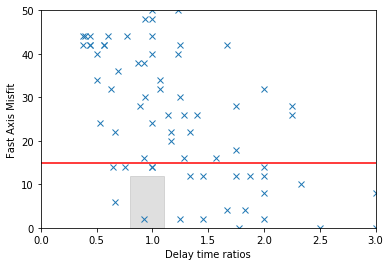

In [110]:
### Current Problem:
import scipy
import pandas as pd
import seaborn as sns
from matplotlib.patches import Ellipse


##########################################################################################
plt.figure(figsize=(16,9))

plt.subplot(2,3,1)
station = station_list[7]
station ='LLS'
print(station)
print(method)

method = ['CrossC','Eig3D','TransM','EigM']
method = method[0]
station_l,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_1,dfast_dir_1,lag_1,dlag_1,SNR = read_SKS_methods(save_loc,method,station)
method = ['CrossC','Eig3D','TransM','EigM']
method = method[1]
station_l,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_2,dfast_dir_2,lag_2,dlag_2,SNR = read_SKS_methods(save_loc,method,station)
method = ['CrossC','Eig3D','TransM','EigM']
method = method[2]
station_l,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_3,dfast_dir_3,lag_3,dlag_3,SNR = read_SKS_methods(save_loc,method,station)
method = ['CrossC','Eig3D','TransM','EigM']
method = method[3]
station_l,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_4,dfast_dir_4,lag_4,dlag_4,SNR = read_SKS_methods(save_loc,method,station)

##########################################################################################
p=sns.kdeplot(fast_dir_1, shade=True)

x,y = p.get_lines()[0].get_data()
#care with the order, it is first y
#initial fills a 0 so the result has same length than x
cdf = scipy.integrate.cumtrapz(y, x, initial=0)

#nearest_05 = np.abs(cdf-0.5).argmin()
#nearest_025 = np.abs(cdf-0.25).argmin()
#nearest_075 = np.abs(cdf-0.75).argmin()
#x_quarter = x[nearest_075]
#y_quarter = y[nearest_075]

nearest_05 = y.argmax()
nearest_025 = np.abs(cdf-0.25).argmin()
nearest_075 = np.abs(cdf-0.75).argmin()


x_median = x[nearest_05]
y_median = y[nearest_05]

x_quarter2 = x_median-max(nearest_025-nearest_075,nearest_075-nearest_025)/2
y_quarter2 = y_median

x_quarter = x_median+max(nearest_025-nearest_075,nearest_075-nearest_025)/2
y_quarter = y_median

plt.vlines(x_median, 0, y_median)
plt.vlines(x_quarter,0,y_quarter,'g',linewidth=4)
plt.vlines(x_quarter2,0,y_quarter2,'b')
plt.vlines(fast_dir[np.where(station_Chev==station)][0],0,y_median, color='red')
plt.vlines(fast_dir[np.where(station_Chev==station)][0]-dfast_dir[np.where(station_Chev==station)][0],0,y_median, color='red')
print('CrossC ',x_median)
##########################################################################################
plt.subplot(2,3,2)
p=sns.kdeplot(fast_dir_2, shade=True)

x,y = p.get_lines()[0].get_data()
#care with the order, it is first y
#initial fills a 0 so the result has same length than x
cdf = scipy.integrate.cumtrapz(y, x, initial=0)

#nearest_05 = np.abs(cdf-0.5).argmin()
#nearest_025 = np.abs(cdf-0.25).argmin()
#nearest_075 = np.abs(cdf-0.75).argmin()
#x_quarter = x[nearest_075]
#y_quarter = y[nearest_075]

nearest_05 = y.argmax()
nearest_025 = np.abs(cdf-0.25).argmin()
nearest_075 = np.abs(cdf-0.75).argmin()


x_median = x[nearest_05]
y_median = y[nearest_05]

x_quarter2 = x_median-max(nearest_025-nearest_075,nearest_075-nearest_025)/2
y_quarter2 = y_median

x_quarter = x_median+max(nearest_025-nearest_075,nearest_075-nearest_025)/2
y_quarter = y_median

plt.vlines(x_median, 0, y_median)
plt.vlines(x_quarter,0,y_quarter,'g',linewidth=4)
plt.vlines(x_quarter2,0,y_quarter2,'b')
plt.vlines(fast_dir[np.where(station_Chev==station)][0],0,y_median, color='red')
plt.vlines(fast_dir[np.where(station_Chev==station)][0]-dfast_dir[np.where(station_Chev==station)][0],0,y_median, color='red')
print('Eig3D ',x_median)
##########################################################################################
plt.subplot(2,3,3)
p=sns.kdeplot(fast_dir_3, shade=True)

x,y = p.get_lines()[0].get_data()
#care with the order, it is first y
#initial fills a 0 so the result has same length than x
cdf = scipy.integrate.cumtrapz(y, x, initial=0)

#nearest_05 = np.abs(cdf-0.5).argmin()
#nearest_025 = np.abs(cdf-0.25).argmin()
#nearest_075 = np.abs(cdf-0.75).argmin()
#x_quarter = x[nearest_075]
#y_quarter = y[nearest_075]

nearest_05 = y.argmax()
nearest_025 = np.abs(cdf-0.25).argmin()
nearest_075 = np.abs(cdf-0.75).argmin()



x_median = x[nearest_05]
y_median = y[nearest_05]

x_quarter2 = x_median-max(nearest_025-nearest_075,nearest_075-nearest_025)/2
y_quarter2 = y_median

x_quarter = x_median+max(nearest_025-nearest_075,nearest_075-nearest_025)/2
y_quarter = y_median

plt.vlines(x_median, 0, y_median)
plt.vlines(x_quarter,0,y_quarter,'g',linewidth=4)
plt.vlines(x_quarter2,0,y_quarter2,'b')
plt.vlines(fast_dir[np.where(station_Chev==station)][0],0,y_median, color='red')
plt.vlines(fast_dir[np.where(station_Chev==station)][0]-dfast_dir[np.where(station_Chev==station)][0],0,y_median, color='red')
print('TransM ',x_median)
##########################################################################################

print('width')
print(abs(x_quarter-x_quarter2))

print('Chevrot',fast_dir[np.where(station_Chev==station)][0])
print(-dfast_dir[np.where(station_Chev==station)][0])




## check if within bandwidth for respective method

IndexError: index 0 is out of bounds for axis 0 with size 0

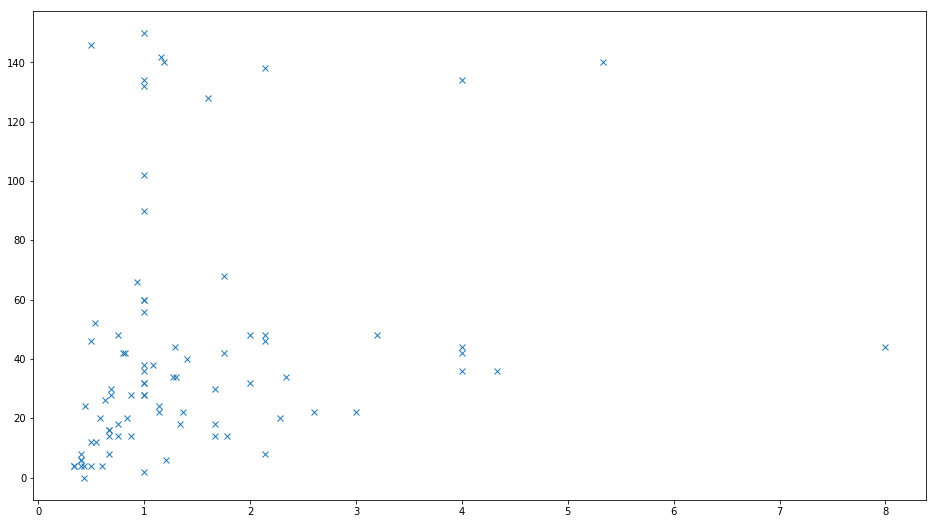

In [52]:



    
max_diff = np.max([fast_dir_3 - fast_dir_1, fast_dir_1 - fast_dir_3],axis=0)
plt.figure(figsize=(16,9))
delta_phi = 12
rho_l = 0.2
rho_u = 0.1
plt.plot(dlag_3/dlag_1,max_diff,'x')
#plt.hlines(fast_dir[np.where(station_Chev==station)][0],0,2, color='red',linewidth=0.5)

print(fast_dir[np.where(station_Chev==station)][0])
plt.fill_between([1-rho_l, 1+rho_u], [0, 0],
                                 [delta_phi,delta_phi],
                                 color='gray', alpha=0.25, label='good')
plt.ylim(0,90)


### give out the EQs, which are in the boundaries


idx = np.where((max_diff<delta_phi) & (dlag_3/dlag_1<1+rho_u) & (dlag_3/dlag_1>1-rho_l))
print(ev_time[idx])
print(fast_dir_1[idx])
print(fast_dir_3[idx])


average_fast =np.mean([fast_dir_1[idx],fast_dir_3[idx]])
print(average_fast)
plt.hlines(average_fast,0,2, color='black',linewidth=0.5)


plt.show()



In [8]:

def _psurf(self,ax,**kwargs):
    """
    Plot an error surface.

    **kwargs
    - cmap = 'magma'
    - vals = (M.lam1-M.lam2) / M.lam2
    - ax = None (creates new)
    """

    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'magma'

    if 'vals' not in kwargs:
        kwargs['vals'] = (self.lam1-self.lam2) / self.lam2

    # error surface
    cax = ax.contourf(self.lags,self.degs,kwargs['vals'],26,cmap=kwargs['cmap'])
    cbar = plt.colorbar(cax)
    ax.set_ylabel(r'Fast Direction ($^\circ$)')
    ax.set_xlabel('Delay Time (' + self.units + ')')

    # confidence region
    if 'conf95' in kwargs and kwargs['conf95'] == True:
        ax.contour(self.lags,self.degs,self.errsurf,levels=[self.conf_95()])

    # marker
    if 'marker' in kwargs and kwargs['marker'] == True:
        ax.errorbar(self.lag,self.fast,xerr=self.dlag,yerr=self.dfast)

    ax.set_xlim([self.lags[0,0], self.lags[-1,0]])
    ax.set_ylim([self.degs[0,0], self.degs[0,-1]])

    # optional title
    if 'title' in kwargs:
        ax.set_title(kwargs['title']) 

    # add info in text box
    if 'info' in kwargs and kwargs['info'] == True:
        textstr = '$\phi=%.1f\pm%.1f$\n$\delta t=%.2f\pm%.2f$'%\
                    (self.fast,self.dfast,self.lag,self.dlag)
        # place a text box in upper left in axes coords
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=props)

    return ax

NameError: name '_psurf' is not defined

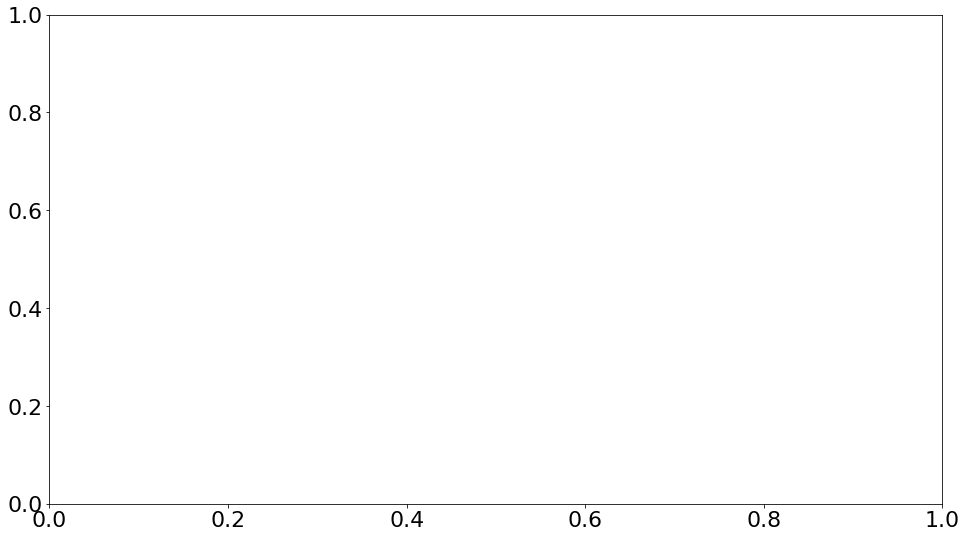

In [39]:
import splitwavepy as sw
## Read in the Error Surfaces

station_list = os.listdir(save_loc)
method = ['CrossC','Eig3D','TransM','EigM']
method = method[3]
#station = station_list[np.random.randint(0,len(station_list))]
station = 'BNALP'

results_path = '/media/hein/home2/SplitWave_Results/Methods/'
fig, ax = plt.subplots(figsize=(16, 9))

station_l,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_1,dfast_dir_1,lag_1,dlag_1,SNR = read_SKS_methods(save_loc,method,station)

tmp = 0
for ievent in ev_time:

    event = ievent.strftime("%Y-%m-%d")
    filename='{0}/{1}/{2}/{2}_{3}.eig'.format(results_path,method,station,event)

    m = sw.load(filename)

    tmp = tmp + m.errsurf 
tmp = tmp/len(ev_time)



##  calc the average errorsurface
m.errsurf = tmp

ax = _psurf(m,ax,marker=True,conf95=True,title='{0}, method={1}, {2}'.format(station,method,event),info=True)


#plt.contour(np.transpose(m.errsurf),vmin=np.min(m.errsurf),vmax=np.max(m.errsurf),levels=[m.conf_95],cmap='magma_r')
plt.savefig('/media/hein/home2/SplitWave_Results/Error_surfaces/{0}_errsurf_{1}_{2}.png'.format(station,method,event))

#plt.xlim(0,3)

#print(m.errsurf)
## ACB_2015-12-04.eig

42.2976645295
12.6494941177


ValueError: setting an array element with a sequence.

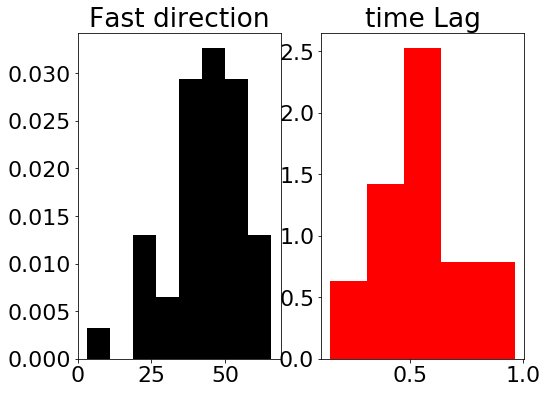

In [42]:
## make list of events coordinates
## make list of all station coordinates


#print(idx)
#data = fast_dir_1.copy()

# ax.plot(fast_dir[np.where(station_Chev==station)][0],dt[np.where(station_Chev==station)][0],'rx')

# u=fast_dir[np.where(station_Chev==station)][0]     #x-position of the center
# v=dt[np.where(station_Chev==station)][0]    #y-position of the center
# a=dfast_dir[np.where(station_Chev==station)][0]     #radius on the x-axis
# b=dtlag[np.where(station_Chev==station)][0]    #radius on the y-axis

# t = np.linspace(0, 2*np.pi, 100)
# ax.plot( u+a*np.cos(t) , v+b*np.sin(t),color='red' )


# #plot red circle around 
# #plt.figure()#
# #ax = plt.gca()

# data = np.vstack((fast_dir_1,lag_1))
# d = {'fast': fast_dir_1, 'lag': lag_1}
# df = pd.DataFrame(d)

# sns.jointplot(x="fast", y="lag", data=df, kind="kde",color='lightsalmon')

# #plt.grid(color='lightgrey',linestyle='--',ax=ax)
# plt.show()

#sb.plt.show()



#plt.plot(fast_dir[np.where(station_Chev==station)][0],dt[np.where(station_Chev==station)][0],'rx')


# f, ax = plt.subplots(figsize=(6, 6))
# cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
# sns.kdeplot(df.x, df.y, cmap=cmap, n_levels=60, shade=True);

## check agreement and make single station measurement

#plt.plot(b[0:-1],n)
#plt.show()

#print(dlag[np.where(station_Chev==station)][0])

### plot together on map and see if any correlation with coordinates

#### Plot THE HISTOGRAM of CHEVROT

plt.figure(figsize=(8,6))
plt.subplot2grid((1,2), (0,0), colspan=1, rowspan=1)
nbins=10
fast_dir = fast_dir
bins, ang, patches = plt.hist(fast_dir,bins='auto', color='black', normed=1)
phi = ang[np.where(bins==bins.max())][0]
mu = np.mean(fast_dir)
sigma = np.std(fast_dir)
plt.title('Fast direction')

print(phi)
print(sigma)
x = ang[0:-1]
y = bins

plt.subplot2grid((1,2), (0,1), colspan=1, rowspan=1)
nbins=5
bins, ang, patches = plt.hist(dt,bins=nbins, color='red', normed=1)
phi = ang[np.where(bins==bins.max())][0]
mu = np.mean(dt)
sigma = np.std(dt)
#print(mu)
#print(sigma)
x = ang[0:-1]
y = bins
plt.title('time Lag')


station_l = []
lat_l = []
lon_l = []

fi = np.zeros((len(station_list)))
dt_tmp = np.zeros(len(station_list))

for i in range(0,len(station_list)-1):
    

    st_l,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir_1,dfast_dir_1,lag_1,dlag_1,SNR = read_SKS_methods(save_loc,method,station_list[i])
    station_l.append(st_l[0])    
    lat_l.append(st_lat[0])
    lon_l.append(st_lon[0])

    fi[i] = fast_dir[np.where(station_Chev==station_list[i])]
    dt_tmp[i]=dtlag[np.where(station_Chev==station_list[i])]
    
station_l = np.asarray(station_l)
lat_l = np.asarray(lat_l)
lon_l = np.asarray(lon_l)
print(fi)

print(station_l)

print('Average time lag',np.mean(dt))
print('Average time lag Error',np.mean(dtlag))

print('Average fast direction',np.mean(fast_dir))
print('Average fast direction Error',np.mean(dfast_dir))

    

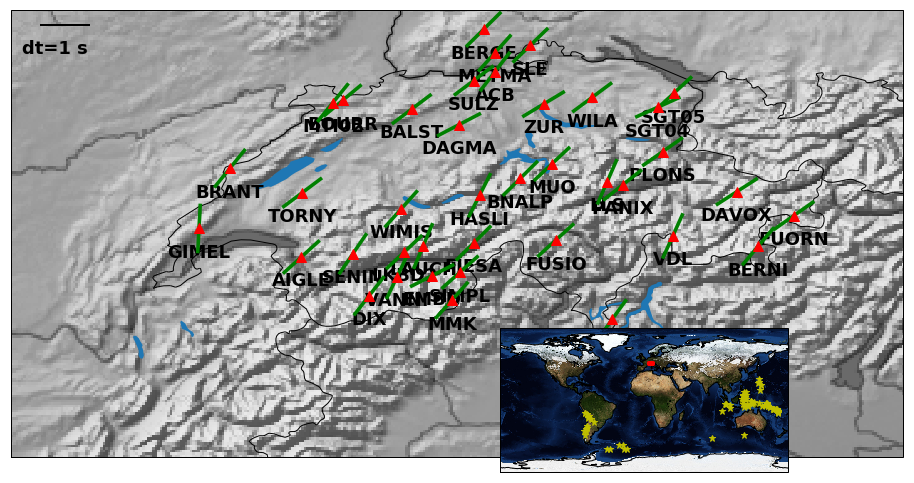

In [44]:
## improve Map
## make Topographic one
##### MOVE ALL THE PLOTTING DOWN HERE
### to make a map of study area
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
#from scalebar import scale_bar

figpath='/media/hein/home2/SplitWave_Results/Project_images'

plt.rcParams.update({'font.size': 18})
## use topography map?
plt.figure(figsize=(16,9))

proj = ccrs.PlateCarree()

ax = plt.axes(projection=proj)
#ax = plt.axes([0.2,0.2,0.75,0.75])
ax.set_extent([5, 11, 45, 48],proj)

#ax = fig.add_axes([0.2,0.2,0.75,0.75])    


#ax.set_extent([0, 45, 0, 90],proj)

places =  cfeature.NaturalEarthFeature('cultural','populated_places','10m',facecolor='black')
land = cfeature.NaturalEarthFeature('physical','land','10m',
            edgecolor='k',facecolor='lightgoldenrodyellow',)

rivers = cfeature.NaturalEarthFeature(category='physical',name='rivers_lake_centerlines',scale='110m')

graticules = cfeature.NaturalEarthFeature(category='physical',name='graticules_1',scale='110m',facecolor='gray')
bounding_box = cfeature.NaturalEarthFeature(category='physical',name='wgs84_bounding_box',scale='10m',facecolor='none')
physical_building_blocks = cfeature.NaturalEarthFeature(category='physical',name='land_ocean_label_points',scale='10m',facecolor='gray')


geography_regions_points=cfeature.NaturalEarthFeature(
    category='physical',
    name='geography_regions_elevation_points',
    scale='10m',
    facecolor='black')

borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land','10m',
            edgecolor='black',facecolor='none')
lakes = cfeature.NaturalEarthFeature(category='physical',name='lakes_europe',scale='10m')
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
geoprahic_lines = cfeature.NaturalEarthFeature(
    category='physical',
    name='geographic_lines',
    scale='10m',
    facecolor='black')





SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

#ax.add_feature(rivers)
ax.add_feature(lakes)
ax.add_feature(states_provinces, edgecolor='none')
ax.add_feature(borders)
#ax.add_feature(geoprahic_lines)#
#ax.add_feature(graticules)
#ax.add_feature(geography_regions_points)

#ax.background_img()
ax.background_img(name='gray-earth', resolution='low')

ax.plot(lon_l,lat_l,'^r',transform=ccrs.PlateCarree(),markersize=10,zorder=11)

for i in range(0,len(station_list)-1):
    ax.annotate(station_l[i],(lon_l[i],lat_l[i]-0.1),transform=ccrs.PlateCarree(),
        ha='center',va='top',weight='bold')
    
r = dtlag
phi = fast_dir

for i in range(0,len(phi)):
    u,v = calc_u_v(r[i],phi[i])
    ax.quiver(lon_l[i], lat_l[i], u, v,pivot='mid',color='green',width=0.004, zorder=10,headlength=0, headwidth = 1)    
    
    
ax.quiver(5+0.2,48-0.1,1,0,width=0.003,color='black',headlength=0, headwidth = 1)
ax.annotate('dt=1 s',(5+0.3,48-0.2),transform=ccrs.PlateCarree(), ha='center',va='top',weight='bold')
#ax.background_img(name='BM', resolution='low')
#ax.background_img()
ext = [5, 11, 45, 48]

############# For Small Plot

sub_ax = plt.axes([0.55,0.12,0.25,0.25], projection=proj)
# Add coastlines and background
sub_ax.coastlines()
sub_ax.background_img()
# Plot box with position of main map
extent_box = sgeom.box(ext[0],ext[2],ext[1],ext[3])

sub_ax.add_geometries([extent_box], proj, color='none',
                      edgecolor='red', linewidth=3)

sub_ax.background_img()
sub_ax.plot(ev_lon,ev_lat,'*y',transform=proj,markersize=7)
#scale_bar(ax,(0.75,0.05),10)

### plot EQ location and Great circle path
plt.savefig('{0}/Station_overview.png'.format(figpath),dpi=150)
plt.show()



In [41]:
print(len(lon_l))

0



### how to add background image:
## downloda files from Natural Earth data
## convert to png
## add to  /home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/cartopy/data/raster/natural_earth
## make entry in images.json


In [ ]:

print(0.005*16)

def main():
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([80, 170, -45, 30])

    # Put a background image on for nice sea rendering.
    ax.stock_img()
#    pyguymer.add_map_background(ax, resolution = "large4096px")

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(states_provinces, edgecolor='gray')

    # Add a text annotation for the license information to the
    # the bottom right corner.


    plt.show()


if __name__ == '__main__':
    main()
    
    

In [ ]:

plt.show()

(-0.087155742747658166, -0.99619469809174555)


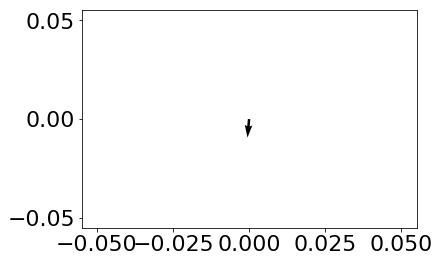

In [34]:


import matplotlib.pyplot as plt
import numpy as np

import cartopy
import cartopy.crs as ccrs

def calc_u_v(r,phi):
    
    if (phi>=0 and phi<=90):
        phi=90-phi
        u = r*np.cos(np.deg2rad(phi))
        v = r*np.sin(np.deg2rad(phi))
    elif (phi>90 and phi<=180):
        phi=180-phi
        u = r*np.sin(np.deg2rad(phi))
        v = -r*np.cos(np.deg2rad(phi))    
    elif (phi>180 and phi<=270):
        phi=270-phi
        u = -r*np.cos(np.deg2rad(phi))
        v = -r*np.sin(np.deg2rad(phi))    
    elif (phi>270 and phi<=360):
        phi=360-phi
        u = -r*np.sin(np.deg2rad(phi))
        v = r*np.cos(np.deg2rad(phi))    
    elif (phi>=-90 and phi<0):
        phi=abs(phi)
        u = -r*np.sin(np.deg2rad(phi))
        v = r*np.cos(np.deg2rad(phi))            
    elif (phi>=-180 and phi<-90):
        phi=180-abs(phi)
        u = -r*np.sin(np.deg2rad(phi))
        v = -r*np.cos(np.deg2rad(phi))                    
        
    return u,v

r = 1
phi= -175

u,v = calc_u_v(r,phi)
print(u,v)


#ax = plt.axes()
plt.quiver(0, 0, u, v,color='black')
#plt.ylim(0,2)

#plt.xlim(0,2)
plt.show()



def sample_data(shape=(20, 30)):
    """
    Returns ``(x, y, u, v, crs)`` of some vector data
    computed mathematically. The returned crs will be a rotated
    pole CRS, meaning that the vectors will be unevenly spaced in
    regular PlateCarree space.

    """
    crs = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)

    x = np.linspace(311.9, 391.1, shape[1])
    y = np.linspace(-23.6, 24.8, shape[0])

    x2d, y2d = np.meshgrid(x, y)
    u = 10 * (2 * np.cos(2 * np.deg2rad(x2d) + 3 * np.deg2rad(y2d + 30)) ** 2)
    v = 20 * np.cos(6 * np.deg2rad(x2d))

    return x, y, u, v, crs


def main():
    
    plt.figure(figsize=(20,10))
    ax = plt.axes(projection=ccrs.Orthographic(-10, 65))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0)
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

    ax.set_global()
    ax.gridlines()

    x, y, u, v, vector_crs = sample_data()
    ax.quiver(x, y, u, v, transform=vector_crs)

    plt.show()


#if __name__ == '__main__':
#    main()



In [ ]:

#from netCDF4 import Dataset, MFDataset, num2date
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from matplotlib import cm
import cartopy.crs as ccrs
#from cmocean import cm as cmo

import cartopy.mpl.geoaxes

import sys
import os
from cartopy.util import add_cyclic_point
#os.environ["CARTOPY_USER_BACKGROUNDS"] = "/home/hein/Documents/cartopy/"
os.environ["CARTOPY_USER_BACKGROUNDS"] ='/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/cartopy/data/raster/natural_earth/'

import json

# filename='/home/hein/Documents/cartopy/images.json'
# with open(filename, "r") as f:
#     data = json.loads(f.read())
# #json.loads()
# print(data)

#read_user_background_images(True)

plt.figure(figsize=(13,6.2))
    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.background_img(name='ne_shaded', resolution='low')
ax.background_img(name='gray-earth', resolution='low')



mm = ax.pcolormesh(lon_cyc,\
                   lat,\
                   temp_cyc,\
                   vmin=-2,\
                   vmax=30,\
                   transform=ccrs.PlateCarree(),\
                   cmap=cmo.balance )
ax.coastlines(resolution='110m');



In [144]:
# Import modules ...
import cartopy
import os

# Print path ...
print os.path.join(cartopy.__path__[0], "data", "raster", "natural_earth")

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/cartopy/data/raster/natural_earth


In [155]:
os.getenv('CARTOPY_USER_BACKGROUNDS')

'/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/cartopy/data/raster/natural_earth/'

In [159]:
name='gray-earth'
resolution='low'
bgdir = os.getenv('CARTOPY_USER_BACKGROUNDS')
if bgdir is None:
    bgdir = os.path.join(config["repo_data_dir"],
                         'raster', 'natural_earth')
print(bgdir)
print(name)
    # now get the filename we want to use:
print(_USER_BG_IMGS)
try:
    fname = _USER_BG_IMGS[name][resolution]
    print(fname)
except KeyError:
    msg = ('Image "{}" and resolution "{}" are not present in '
           'the user background image metadata in directory "{}"')
    raise ValueError(msg.format(name, resolution, bgdir))
# Now obtain the image data from file or cache:
fpath = os.path.join(bgdir, fname)

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/cartopy/data/raster/natural_earth/
gray-earth
{u'__comment__': u'JSON file specifying the image to use for a given type/name and resolution. Read in by cartopy.mpl.geoaxes.read_user_background_images.', u'BM': {u'__comment__': u'Blue Marble Next Generation, July ', u'__source__': u'https://neo.sci.gsfc.nasa.gov/view.php?datasetId=BlueMarbleNG-TB', u'high': u'BlueMarble.jpeg', u'__projection__': u'PlateCarree', u'low': u'BlueMarble.jpeg'}}


ValueError: Image "gray-earth" and resolution "low" are not present in the user background image metadata in directory "/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/cartopy/data/raster/natural_earth/"

In [160]:
background_img(self, name='ne_shaded', resolution='low', extent=None,
                       cache=False)

NameError: name 'background_img' is not defined

In [170]:
import os
import json

bgdir = os.getenv('CARTOPY_USER_BACKGROUNDS')
if bgdir is None:
    bgdir = os.path.join(config["repo_data_dir"],
                         'raster', 'natural_earth')
json_file = os.path.join(bgdir, 'images.json')

print(json_file)
print(js_obj)
with open(json_file, 'r') as js_obj:
    dict_in = json.load(js_obj)
for img_type in dict_in:
    _USER_BG_IMGS[img_type] = dict_in[img_type]

print(_USER_BG_IMGS)
verify=True    
if verify:
    required_info = ['__comment__', '__source__', '__projection__']
    for img_type in _USER_BG_IMGS:
        if img_type == '__comment__':
            # the top level comment doesn't need verifying:
            pass
        else:
            # check that this image type has the required info:
            for required in required_info:
                if required not in _USER_BG_IMGS[img_type]:
                    msg = ('User background metadata file "{}", '
                           'image type "{}", does not specify '
                           'metadata item "{}"')
                    raise ValueError(msg.format(json_file, img_type,
                                                required))
            for resln in _USER_BG_IMGS[img_type]:
                # the required_info items are not resolutions:
                if resln not in required_info:
                    img_it_r = _USER_BG_IMGS[img_type][resln]
                    test_file = os.path.join(bgdir, img_it_r)
                    if not os.path.isfile(test_file):
                        msg = 'File "{}" not found'
                        raise ValueError(msg.format(test_file))

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/cartopy/data/raster/natural_earth/images.json
<closed file '/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/cartopy/data/raster/natural_earth/images.json', mode 'r' at 0x7fcdea4b00c0>
{u'__comment__': u'JSON file specifying the image to use for a given type/name and resolution. Read in by cartopy.mpl.geoaxes.read_user_background_images.', u'BM': {u'__comment__': u'Blue Marble Next Generation, July ', u'__source__': u'https://neo.sci.gsfc.nasa.gov/view.php?datasetId=BlueMarbleNG-TB', u'high': u'BlueMarble.jpeg', u'__projection__': u'PlateCarree', u'low': u'BlueMarble.jpeg'}, u'ne_shaded': {u'__comment__': u'Natural Earth shaded relief', u'__source__': u'http://www.naturalearthdata.com/downloads/50m-raster-data/50m-natural-earth-1/', u'__projection__': u'PlateCarree', u'low': u'50-natural-earth-1-downsampled.png'}, u'gray-earth': {u'__comment__': u'Natural Earth shaded relief', u'__source__': u'http://www.naturaleart

ValueError: File "/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/cartopy/data/raster/natural_earth/BlueMarble.jpeg" not found